In [1]:
from PIL import Image
import PIL
import os
import tifffile
import glob
import torch; torch.manual_seed(0)
import numpy as np
import seaborn as sns
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import multiprocessing
import os, sys
import torchvision.transforms as T
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
%load_ext autoreload
%autoreload 2
from utils import create_random_patches, ProgressMeter, AverageMeter, save_checkpoint, TiffDataset
from os.path import dirname, join, abspath
sys.path.insert(0, abspath(join(dirname("__file__"), '..')))

PIL.Image.MAX_IMAGE_PIXELS = 933120000

/home/kangzigi/miniconda3/envs/pixel-ai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Compare non-empty and empty patches

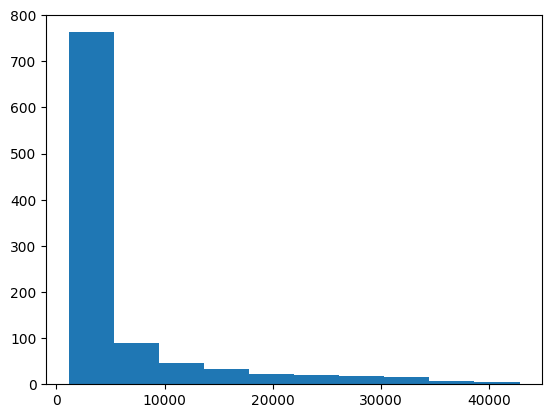

Channel DAPI(0) median = 1908.0, mean = 5582.4658203125, std = 7780.330018958699


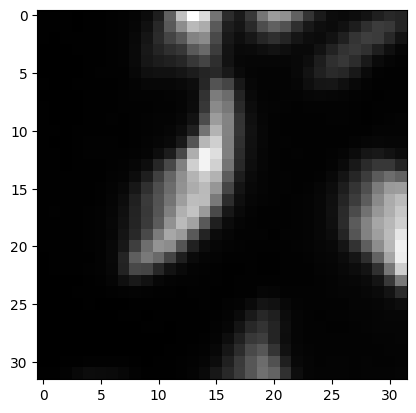

In [44]:
im_core_1_patch_0 = tifffile.imread('/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/randomly_generated/TMA_18_810/core44/patch_1408_1760.tiff')
im_core_1_patch_0[0,:,:]

plt.hist(im_core_1_patch_0[0,:,:].flatten())
plt.show()
print("Channel DAPI(0) median = {}, mean = {}, std = {}".format(np.median(im_core_1_patch_0[0,:,:].flatten()), 
                                                      np.mean(im_core_1_patch_0[0,:,:].flatten()), 
                                                      np.std(im_core_1_patch_0[0,:,:].flatten())))

plt.imshow(im_core_1_patch_0[0,:,:], cmap='gray')
plt.show()

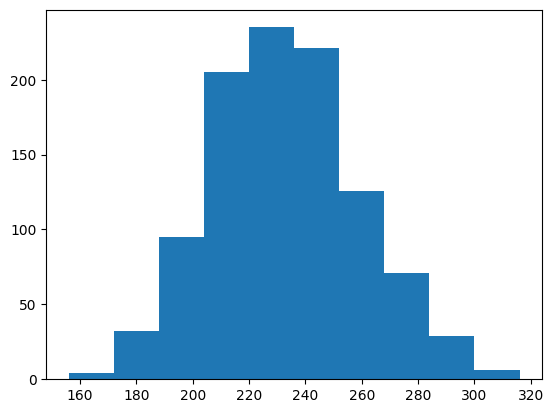

Channel DAPI(0) median = 231.0, mean = 232.5146484375, std = 25.941787677862116, max = 316


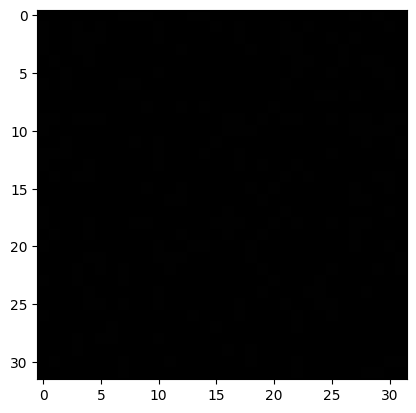

In [126]:
im_core_1_patch_1 = tifffile.imread('/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/randomly_generated/TMA_18_810/core44/patch_1376_2656.tiff')
im_core_1_patch_1[0,:,:]

plt.hist(im_core_1_patch_1[0,:,:].flatten())
plt.show()
print("Channel DAPI(0) median = {}, mean = {}, std = {}, max = {}".format(np.median(im_core_1_patch_1[0,:,:].flatten()), 
                                                      np.mean(im_core_1_patch_1[0,:,:].flatten()), 
                                                      np.std(im_core_1_patch_1[0,:,:].flatten()), 
                                                      np.max(im_core_1_patch_1[0,:,:].flatten())))

plt.imshow(im_core_1_patch_1[0,:,:], cmap='gray', vmin=0, vmax=65000)
plt.show()

# Calculate DAPI density (channel 0) distribution

In [3]:
cores_folder = 'TMA_18_810/'
files_path='/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/randomly_generated/{0}'.format(cores_folder)
input_dimensions = (128, 128)
batch_size = 4096

patches_files = [os.path.join(r, fn)
        for r, ds, fs in os.walk(files_path)
        for fn in fs if fn.endswith('.tiff')]
tiff_dataset = TiffDataset(files=patches_files, files_names=patches_files, transform=T.Resize(input_dimensions))

data_loader = torch.utils.data.DataLoader(
    tiff_dataset, batch_size=batch_size, 
    shuffle=None, pin_memory=True, 
    sampler=None
    )

In [4]:
dapi_stat = []

for i, (image, filenames) in enumerate(data_loader): 
    for name in filenames: 
        im_core_patch = tifffile.imread(name)
        dapi_stat.append((np.median(im_core_patch[0,:,:].flatten()), 
                        np.mean(im_core_patch[0,:,:].flatten()), 
                        np.std(im_core_patch[0,:,:].flatten()), 
                        name.split('/')[-1].lower(), 
                        name.split('/')[-2].lower()))

d = pd.DataFrame(dapi_stat, columns=("Median", "Mean", "Std", "Patch", "Core"))

# save the file
d.to_csv("../data/patch_size{}_stat_channel0.csv".format(input_dimensions))

In [5]:
np.shape(d)

(53959, 5)

# Plot channel density distribution per core

In [17]:
def plot_patch_density_percore(data, core, kde=True, element='step', log_scale=True): 
    plot_df = data.loc[data['Core'] == core]
    # sns.histplot(plot_df["Median"], kde=kde, element=element, log_scale=log_scale)
    # sns.histplot(plot_df["Mean"], kde=kde, element=element, log_scale=log_scale)
    # sns.histplot(plot_df["Std"], kde=kde, element=element, log_scale=log_scale)
    sns.histplot(plot_df, kde=kde, element=element, log_scale=log_scale)
    plt.title("{}".format(core))
    plt.show()

In [ ]:
# Read in d

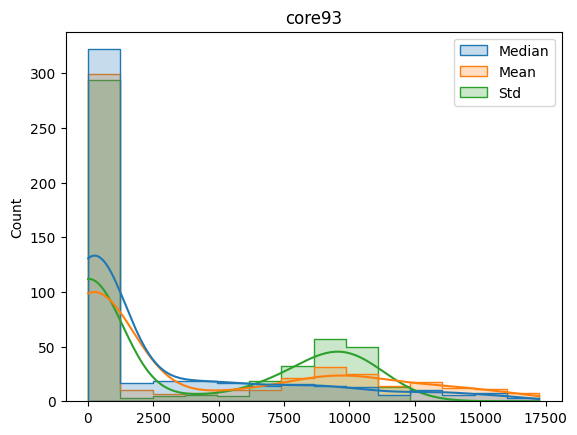

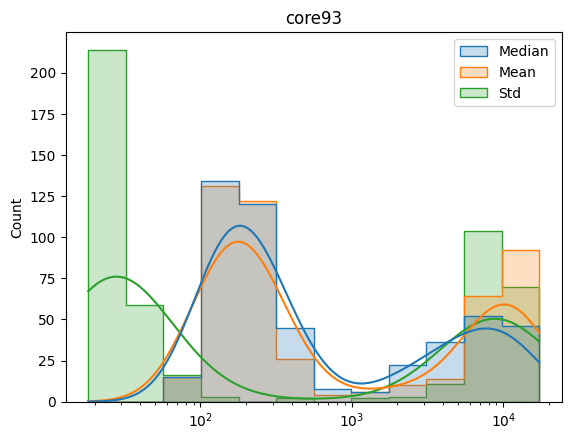

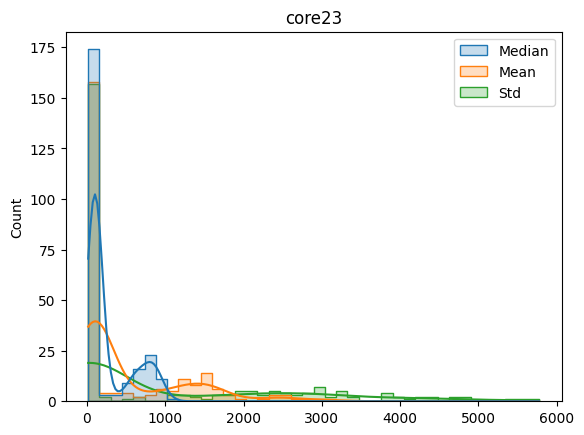

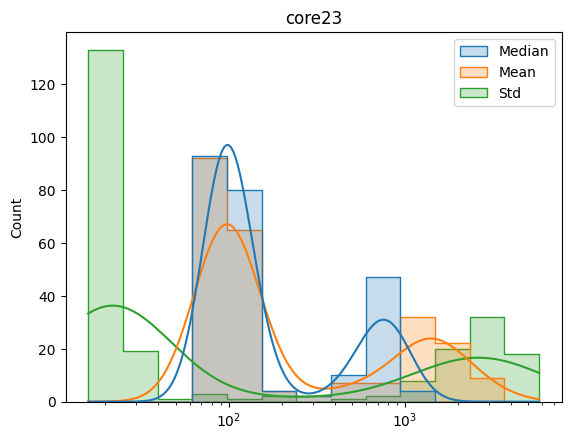

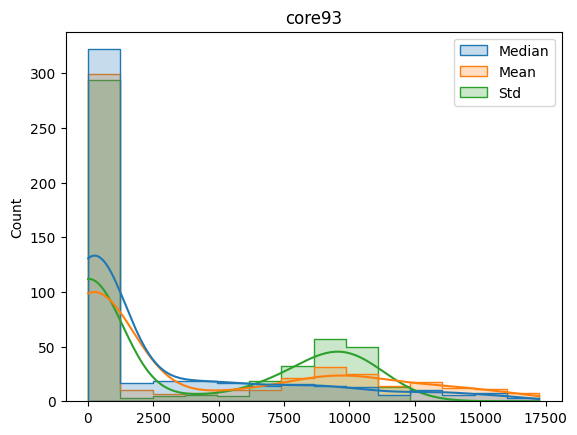

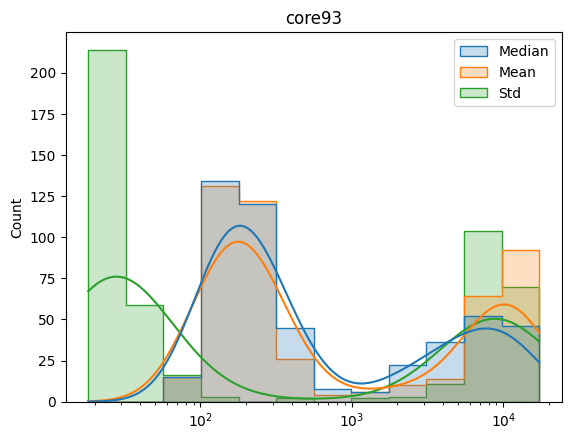

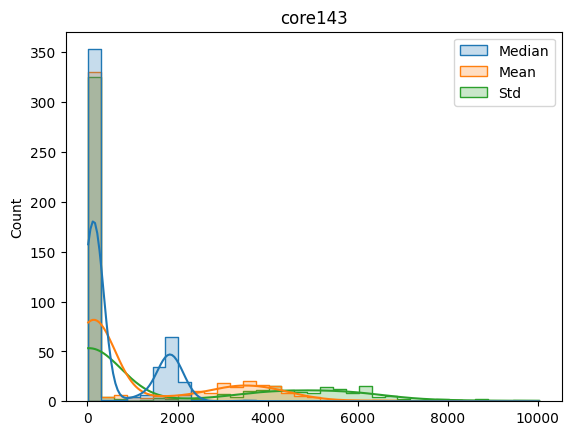

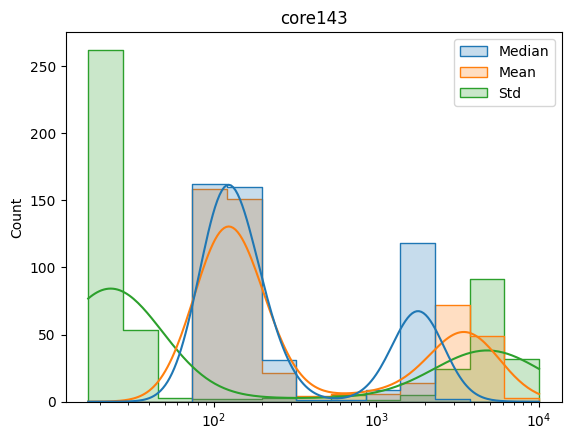

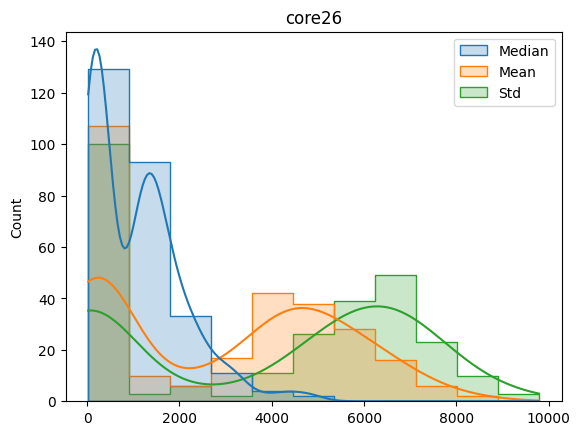

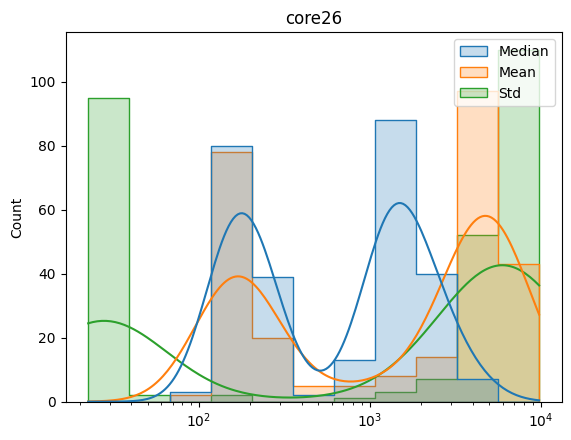

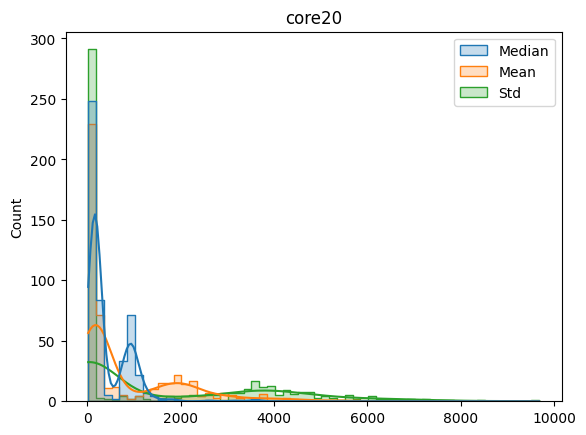

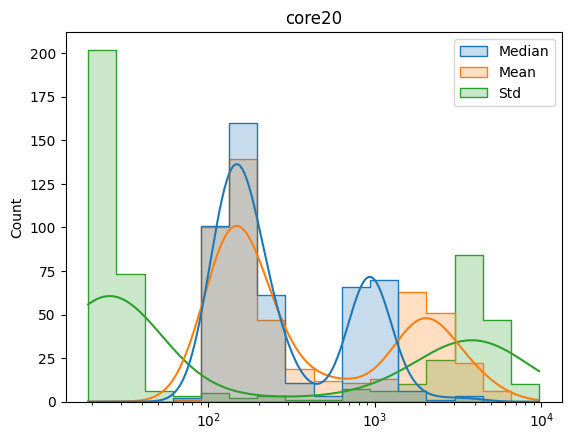

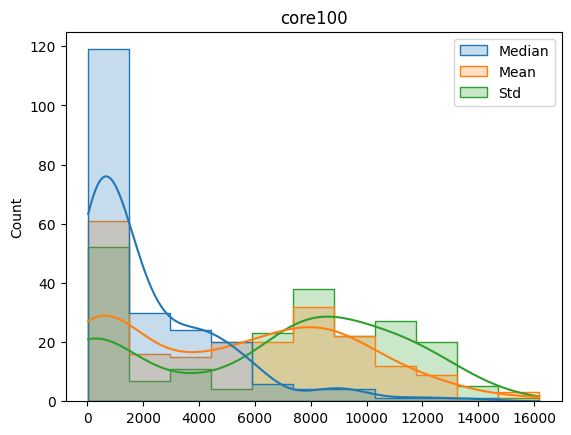

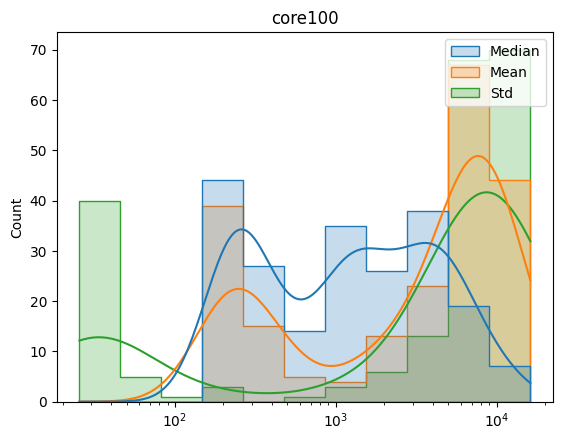

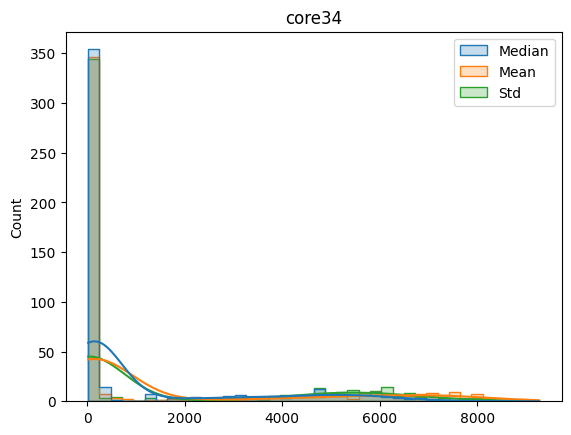

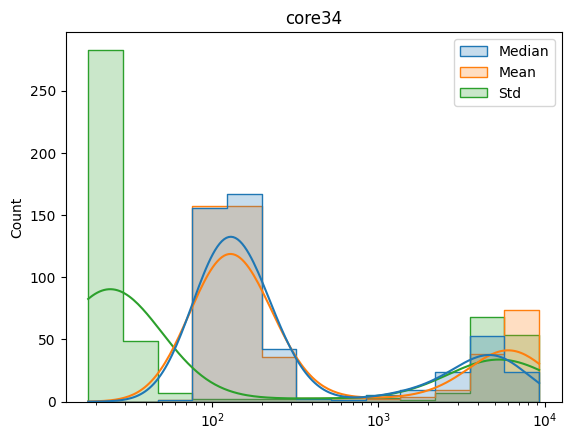

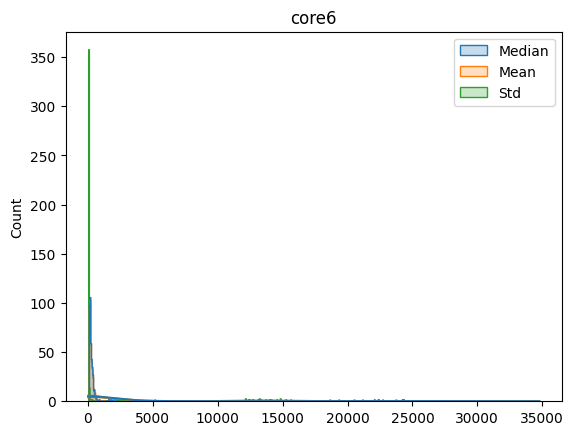

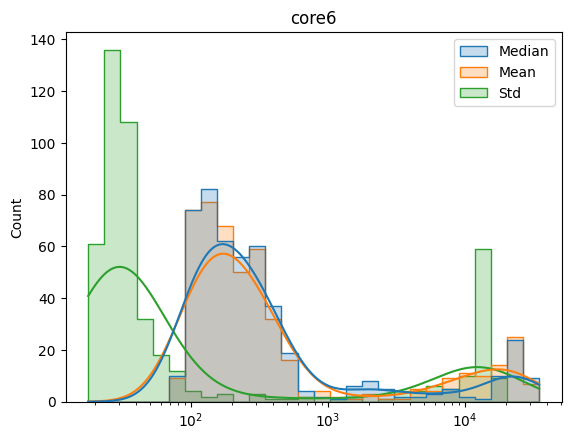

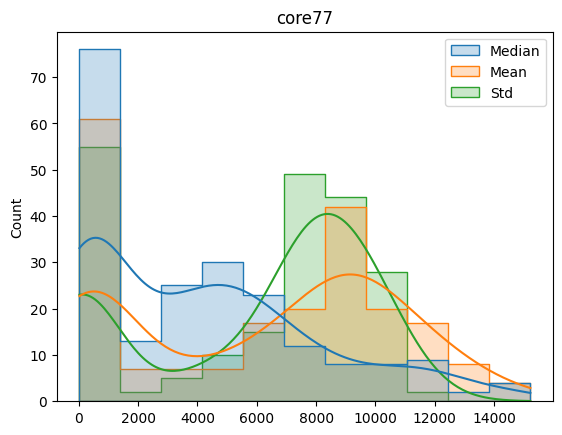

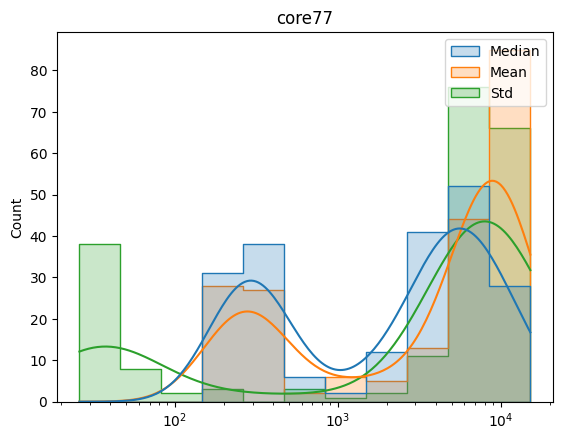

In [18]:
import random
for core in random.choices(np.unique(d["Core"]), k=10): 
    plot_patch_density_percore(d, core, kde=True, element='step', log_scale=False)
    plot_patch_density_percore(d, core, kde=True, element='step', log_scale=True)
